In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score

# load the data

In [2]:
df=pd.read_csv('./dataset/sqliv2.csv',encoding='utf-16')

# EDA for the dataset

In [3]:
df.shape

(33761, 2)

In [4]:
df.dtypes

Sentence    object
Label        int64
dtype: object

In [5]:
df.head()

,Sentence,Label
0,NaN,1
1,""" or pg_sleep ( __TIME__ ) --",1
2,create user name identified by pass123 tempora...,1
3,%29,1
4,' AND 1 = utl_inaddr.get_host_address ( ( S...,1


In [6]:
df.tail()

,Sentence,Label
33756,syrett,0
33757,arrechea bellveh,0
33758,1664,0
33759,almaluez,0
33760,f6lo40r06,0


In [7]:
df.isna().sum()

Sentence    4
Label       0
dtype: int64

In [8]:
df[df['Sentence'].isna()]

,Sentence,Label
0,NaN,1
951,NaN,0
3953,NaN,1
3995,NaN,1


In [9]:
df.dropna(inplace=True)

In [10]:
df.reset_index(drop=True,inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33757 entries, 0 to 33756
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  33757 non-null  object
 1   Label     33757 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 527.6+ KB


In [12]:
df.duplicated().sum()

30

In [13]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True,inplace=True)

In [14]:
df.duplicated().sum()

0

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33727 entries, 0 to 33726
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  33727 non-null  object
 1   Label     33727 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 527.1+ KB


# check the classses distribution

In [16]:
class_distribution=pd.DataFrame(df['Label'].value_counts())

In [17]:
class_distribution

,count
Label,
0,22303
1,11424


# Bar plot that shows the classes distribution

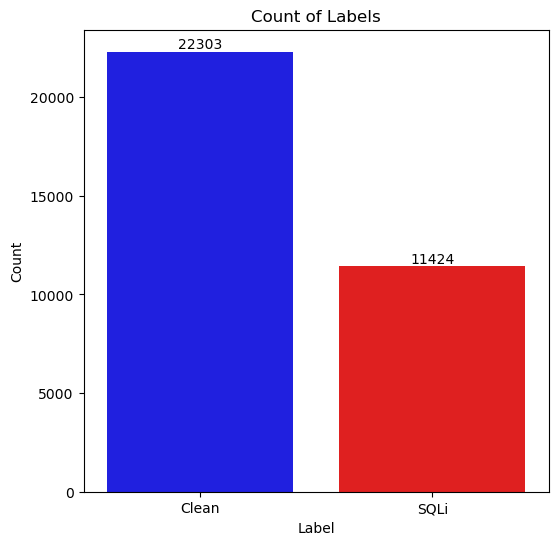

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Suppress warnings
warnings.filterwarnings("ignore")
# Customized bar plot
plt.figure(figsize=(6, 6))
ax = sns.barplot(x='Label', y='count', data=class_distribution, palette=['blue', 'red'])

# Rename the x-axis labels
plt.xticks(ticks=[0, 1], labels=['Clean', 'SQLi'])

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Label')
plt.title('Count of Labels')
plt.ylabel('Count')
plt.show()


# Plot to check if the data is labels is ordered

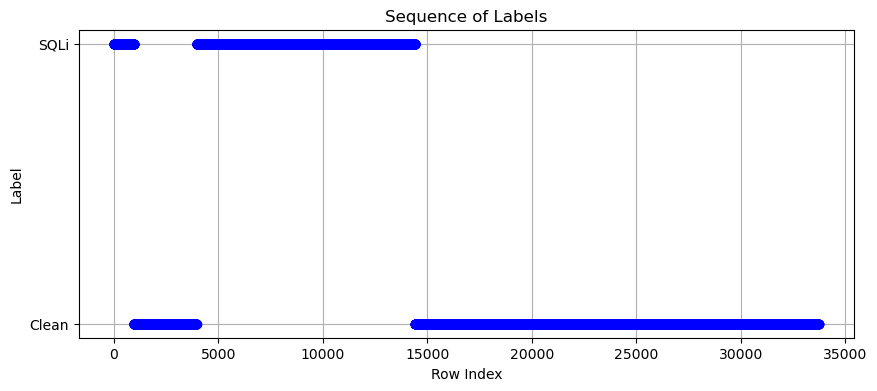

In [19]:
import matplotlib.pyplot as plt

# Plot the labels
plt.figure(figsize=(10, 4))
plt.plot(df['Label'], marker='o', linestyle='', color='b')
plt.title('Sequence of Labels')
plt.xlabel('Row Index')
plt.ylabel('Label')
plt.yticks([0, 1], ["Clean", "SQLi"])
plt.grid(True)
plt.show()


In [20]:
df['Label']

0        1
1        1
2        1
3        1
4        1
        ..
33722    0
33723    0
33724    0
33725    0
33726    0
Name: Label, Length: 33727, dtype: int64

# Data Augmentation

In [21]:
df2=pd.read_csv('./dataset/payload_full.csv')


In [22]:
df2

,payload,length,attack_type,label
0,c/ caridad s/n,14,norm,norm
1,"campello, el",12,norm,norm
2,40184,5,norm,norm
3,1442431887503330,16,norm,norm
4,nue37,5,norm,norm
...,...,...,...,...
31062,"<script a="">"" id=xss src=""http://ha.ckers.org/...",63,xss,anom
31063,"<script a="">"" '' id=xss src=""http://ha.ckers.o...",66,xss,anom
31064,"<script ""a='>'"" id=xss src=""http://ha.ckers.or...",65,xss,anom
31065,"<script a=`>` id=xss src=""http://ha.ckers.org/...",63,xss,anom


In [23]:
df2.shape

(31067, 4)

In [24]:
df2.head()

,payload,length,attack_type,label
0,c/ caridad s/n,14,norm,norm
1,"campello, el",12,norm,norm
2,40184,5,norm,norm
3,1442431887503330,16,norm,norm
4,nue37,5,norm,norm


In [25]:
del df2['length']
del df2['label']

In [26]:
df2.head()

,payload,attack_type
0,c/ caridad s/n,norm
1,"campello, el",norm
2,40184,norm
3,1442431887503330,norm
4,nue37,norm


In [27]:
df2['attack_type'].unique()

array(['norm', 'sqli', 'xss', 'cmdi', 'path-traversal'], dtype=object)

In [28]:
df2.columns

Index(['payload', 'attack_type'], dtype='object')

In [29]:
df2.columns=['Sentence','Label']

In [30]:
df2['Label'].value_counts()

Label
norm              19304
sqli              10852
xss                 532
path-traversal      290
cmdi                 89
Name: count, dtype: int64

In [31]:
df2=df2[df2['Label']=='sqli']

In [32]:
df2.isna().sum()

Sentence    0
Label       0
dtype: int64

In [33]:
df2.duplicated().sum()

0

### Change the label from SQLi to 1, to match the first dataset structure

In [34]:
df2['Label']=1

In [35]:
df2['Label'].value_counts()

Label
1    10852
Name: count, dtype: int64

In [36]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10852 entries, 436 to 30545
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  10852 non-null  object
 1   Label     10852 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 254.3+ KB


In [37]:
df=pd.concat([df,df2])
df.reset_index(drop=True,inplace=True)

In [38]:
df.shape

(44579, 2)

In [39]:
after_redistribution=pd.DataFrame(df['Label'].value_counts())

In [40]:
after_redistribution

,count
Label,
0,22303
1,22276


In [41]:
df.duplicated().sum()

392

In [42]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

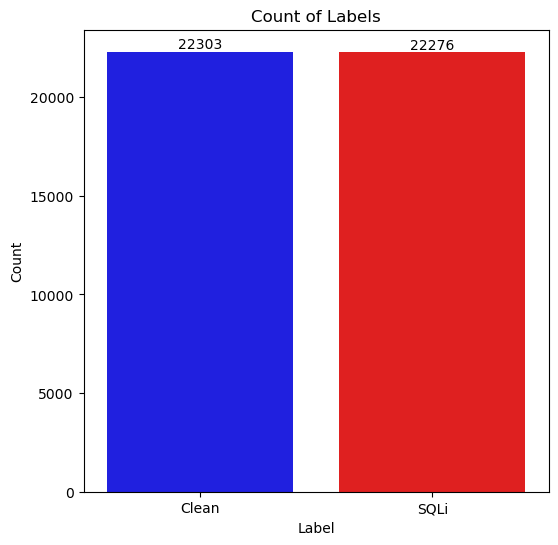

In [43]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Customized bar plot
plt.figure(figsize=(6, 6))
ax = sns.barplot(x='Label', y='count', data=after_redistribution, palette=['blue', 'red'])

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')
plt.xticks(ticks=[0, 1], labels=['Clean', 'SQLi'])
plt.title('Count of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

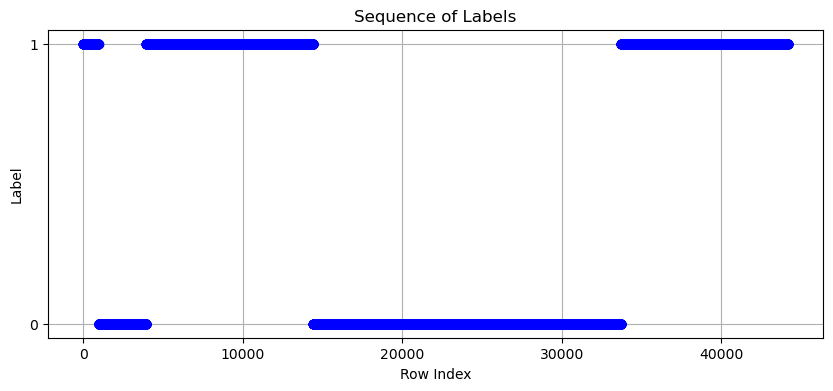

In [44]:
# Plot the labels
plt.figure(figsize=(10, 4))
plt.plot(df['Label'], marker='o', linestyle='', color='b')
plt.title('Sequence of Labels')
plt.xlabel('Row Index')
plt.ylabel('Label')
plt.yticks([0, 1])
plt.grid(True)
plt.show()

In [45]:
df=df.sample(frac=1,random_state=42).reset_index(drop=True)

In [46]:
df.head()

,Sentence,Label
0,friera de valverde,0
1,1'||(select 'ypqa' where 1961=1961 or 6793=(se...,1
2,1') where 2808=2808;select count(*) from domai...,1
3,1' in boolean mode);call regexp_substring(repe...,1
4,"1');select count(*) from generate_series(1,500...",1


# train test split

In [47]:
# split the dataset into training and testing sets
x=df['Sentence']
y=df['Label']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

# Grid Search to find best vectorizer parameters

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,accuracy_score,recall_score


# define the pipline
pipeline=Pipeline(
    [
        ('tfidf',TfidfVectorizer(lowercase=True)), # TfidfVectorizer
        ('clf',RandomForestClassifier(random_state=42))  # random forest
    ]
)

# define the parameters grid

param_grid={
    'tfidf__token_pattern': [
        r"(?u)\b\w+\b",  # Default: alphanumeric tokens
        r"(?u)\b\w+\b|[\"';=()#-]+|/\*|\*/|--" # Alphanumeric + special characters + SQL comments

    ]
}

scoring={
        'accuracy':'accuracy',  # Accuracy
        'recall':'recall'        # Recall

}
# Initialize GridSearchCV

grid_search=GridSearchCV(

pipeline,
    param_grid,
    cv=2,          # 5-fold cross-validation
    scoring=scoring,    # Use multiple scoring metrics
    refit='accuracy'  ,    # Refit the best model on the full dataset using accuracy
    n_jobs=-1  # Use all available CPU cores
    
)
# Perform Grid Search
grid_search.fit(x, y)


# Print the best parameters and scores
print("Best Parameters:", grid_search.best_params_)
print("Best Recall & Accuracy:", grid_search.best_score_)


In [51]:
df.shape

(44187, 2)

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer



# initialize the tf-idf vectorizer

tfidf_vctorizer=TfidfVectorizer(
          max_features=5000,
    analyzer='word',
    token_pattern=r'(?u)\b\w\w+\b|--|[\"\';#\-+()/\*\*/]',
    max_df=0.9,
    min_df=2,
    norm='l2',
    ngram_range=(1, 2)
)


# fit and transform the training data
x_train_vectorized=tfidf_vctorizer.fit_transform(x_train)
x_test_vectorized=tfidf_vctorizer.fit_transform(x_test)

### Train RandomForestClassifier

In [62]:
# initialize and train the model
model=RandomForestClassifier(class_weight={0:1,1:5},random_state=42,min_samples_split=5,min_samples_leaf=2,n_jobs=-1)

model.fit(x_train_vectorized,y_train)

RandomForestClassifier(class_weight={0: 1, 1: 5}, min_samples_leaf=2,
                       min_samples_split=5, n_jobs=-1, random_state=42)

### Random Search

In [65]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint,uniform

# define the parameter distributions for random serach
param_dist={
    'n_estimators':randint(100,300),  # Random integer between 100 and 300
    'max_depth': [None,10,20],    # Fixed choices
    'min_samples_split':randint(2,10),     # Random integer between 2 and 10
    'min_samples_leaf': randint(1,4),       # Random integer between 1 and 4
    'class_weight':[{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 5}, 'balanced'] # Fixed choices    
}
